In [1]:
print('STOCK PREDICTION USING RNN LSTM')
import numpy as np
import pandas as pd
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM
from keras.layers import  Dropout
from keras.models import model_from_json
from keras.models import load_model
from keras import regularizers

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
fmt = '$%.0f'
tick = mtick.FormatStrFormatter(fmt)

%matplotlib inline

STOCK PREDICTION USING RNN LSTM


Using TensorFlow backend.
C:\Users\natan\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\natan\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\natan\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\natan\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
# Plotting the data

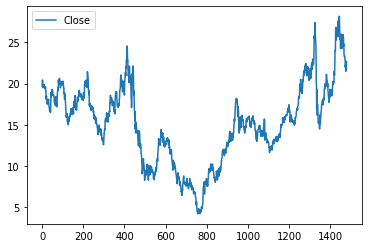

<Figure size 432x288 with 0 Axes>

In [3]:
data_csv = pd.read_csv('Dados/PETR4_Teste.csv')

data_csv[['Close']].plot()
plt.show()
plt.clf()

### Calculating the length of data to use

In [4]:
percentage_of_data = 1.0
data_to_use = int(percentage_of_data*(len(data_csv)-1))

# 80% of data will be of training
train_end = int(data_to_use*0.8)

total_data = len(data_csv)
print("total_data:", total_data)

total_data: 1480


### Arranging the data

In [5]:
start = total_data - data_to_use

# Currently doing prediction only for 1 step ahead
steps_to_predict = 1

#close, sentiment, open, high, low, volume
# Order -> 8,1,2,3,4,5,6,7,9
yt = data_csv.iloc[start:total_data,4] #close
yt1 = data_csv.iloc[start:total_data,6] #sentiment
yt5 = data_csv.iloc[start:total_data,1] #open
yt6 = data_csv.iloc[start:total_data,2] #high
yt7 = data_csv.iloc[start:total_data,3] #low
vt = data_csv.iloc[start:total_data,5] #volume

print("yt head (close) :")
print(yt.head())

yt head (close) :
1    20.40
2    20.43
3    20.08
4    19.50
5    19.68
Name: Close, dtype: float64


### Shifting the data by 1

In [6]:
#shift next day close and next day compund
yt_ = yt.shift(-1) #shifted close
yt1_ = yt1.shift(-1) #shifted compund

#taking only: close, next_close, compund, next_compund, volume, open, high, low
data = pd.concat([yt, yt_, yt1, yt1_, vt, yt5, yt6, yt7], axis=1)
data.columns = ['yt', 'yt_', 'yt1', 'yt1_','vt', 'yt5', 'yt6', 'yt7']

data = data.dropna()
     
print(data[:10])

       yt    yt_       yt1      yt1_        vt    yt5    yt6    yt7
1   20.40  20.43  0.000000  0.000000  30552600  19.81  20.40  19.70
2   20.43  20.08  0.000000  0.000000  36141000  20.33  20.62  20.17
3   20.08  19.50  0.000000  0.000000  28069600  20.48  20.67  19.95
4   19.50  19.68  0.000000  0.000000  29091300  20.11  20.23  19.46
5   19.68  19.83  0.000000 -0.932171  24361100  19.64  19.87  19.46
6   19.83  19.88 -0.932171 -0.816656  17526200  19.77  20.05  19.54
7   19.88  19.72 -0.816656  0.000000  18223600  19.85  20.04  19.70
8   19.72  19.82  0.000000  0.000000  28302400  20.01  20.24  19.69
9   19.82  19.84  0.000000  0.000000  29633900  20.01  20.24  19.69
10  19.84  19.71  0.000000  0.000000  16787800  19.89  19.89  19.60


### Separating data into x and y
**Approach:** Training the machine using ***compund, close price, and next_compund*** to predict ***next_close price***.

In [7]:
# target variable - closed price
# after shifting
y = data['yt_'] #next_close

# close, compund, next_compund, volume, open, high, low   
cols = ['yt', 'yt1', 'yt1_', 'vt', 'yt5', 'yt6', 'yt7']
x = data[cols]

### Preprocessing

In [8]:
scaler_x = preprocessing.MinMaxScaler (feature_range=(-1, 1))
x = np.array(x).reshape((len(x) ,len(cols)))
x = scaler_x.fit_transform(x)

scaler_y = preprocessing.MinMaxScaler (feature_range=(-1, 1))
y = np.array (y).reshape ((len( y), 1))
y = scaler_y.fit_transform (y)

### Train Test Split

In [9]:
X_train = x[0 : train_end,]
X_test = x[train_end+1 : len(x),]    
y_train = y[0 : train_end] 
y_test = y[train_end+1 : len(y)]  

X_train = X_train.reshape (X_train. shape + (1,)) 
X_test = X_test.reshape(X_test.shape + (1,))

### RNN LSTM Model

In [ ]:
batch_size = 32
nb_epoch = 100
neurons = 25
dropout = 0.1

seed = 2016
np.random.seed(seed)

model = Sequential ()
model.add(LSTM(neurons, return_sequences=True, activation='tanh', inner_activation='hard_sigmoid', input_shape=(len(cols), 1)))
model.add(Dropout(dropout))
model.add(LSTM(neurons, return_sequences=True,  activation='tanh'))
model.add(Dropout(dropout))
model.add(LSTM(neurons, activation='tanh'))
model.add(Dropout(dropout))

model.add(Dense(activity_regularizer=regularizers.l1(0.00001), output_dim=1, activation='linear'))
model.add(Activation('tanh'))

print(model.summary())

model.compile(loss='mean_squared_error' , optimizer='RMSprop')
model.fit(X_train, y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_split=0.2)


C:\Users\natan\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(25, return_sequences=True, activation="tanh", input_shape=(7, 1), recurrent_activation="hard_sigmoid")`
  # Remove the CWD from sys.path while we load stuff.
C:\Users\natan\anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activity_regularizer=<keras.reg..., activation="linear", units=1)`


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 7, 25)             2700      
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 25)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 7, 25)             5100      
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 25)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 25)                5100      
_________________________________________________________________
dropout_3 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

### Score Calculation

In [ ]:
score_train = model.evaluate(X_train, y_train, batch_size =1)
score_test = model.evaluate(X_test, y_test, batch_size =1)
print("in train MSE = ", round( score_train ,4)) 
print("in test MSE = ", score_test )

### Saving model

In [ ]:
model_json = model.to_json()
with open("model_rms100e_new.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_rms100e_new.h5")
print("Saved model to disk")

### Predicting on unseen data

In [ ]:
pred = model.predict(X_test) 
pred = scaler_y.inverse_transform(np.array(pred).reshape((len(pred), 1)))

prediction_data = pred[-1]     

print ("Inputs: {}".format(model.input_shape))
print ("Outputs: {}".format(model.output_shape))
print ("Actual input: {}".format(X_test.shape))
print ("Actual output: {}".format(y_test.shape))

print ("prediction data:")
print (prediction_data)

print ("actual data")
X_test = scaler_x.inverse_transform(np.array(X_test).reshape((len(X_test), len(cols))))
print (X_test)

#########################################################################
'''Plotting'''
plt.plot(pred, label="predictions")

y_test = scaler_y.inverse_transform(np.array(y_test).reshape((len( y_test), 1)))
plt.plot([row[0] for row in y_test], label="actual")

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)

ax = plt.axes()
ax.yaxis.set_major_formatter(tick)
plt.show()
plt.clf()
